In [1]:
# # Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


## Data Engineering

In [2]:
import pandas as pd
import logging
logging.basicConfig(level=logging.CRITICAL)

In [3]:
import zipfile
import io
def iterate_file_lines():
    with zipfile.ZipFile(r"data\task1\jetnet_logs.zip") as zf:
        with io.TextIOWrapper(zf.open("jetnet_logs.txt")) as f:
            for line in f:
                yield line

In [4]:
len(list(iterate_file_lines()))

87192

In [5]:
lines = []
i = 0
for line in iterate_file_lines():
    if i >= 100:
        break
    i+=1
    lines.append(line)
print(*lines, sep="\n")

@User92: Action_3 (15/10/19 | 18:08:02) -> Action_1 (15/10/19 | 18:54:49) -> Action_10 (15/10/19 | 20:02:54) -> Action_7 (15/10/19 | 20:26:56) -> Action_0 (15/10/19 | 20:51:09) -> Action_3 (15/10/19 | 22:00:47) -> Action_0 (15/10/19 | 22:49:59) -> Action_7 (15/10/19 | 23:08:43) -> Action_7 (15/10/19 | 23:51:57) -> Action_4 (16/10/19 | 00:10:14) -> Action_8 (16/10/19 | 00:28:14) -> Action_7 (16/10/19 | 01:04:24) -> Action_7 (16/10/19 | 00:47:45) -> Action_3 (16/10/19 | 00:34:58) -> Action_10 (16/10/19 | 00:50:19) -> Action_1 (16/10/19 | 00:54:43) -> Action_1 (16/10/19 | 01:32:37) -> Action_4 (16/10/19 | 01:39:53) -> Action_8 (16/10/19 | 01:35:39) -> Action_5 (16/10/19 | 02:41:46) -> Action_10 (16/10/19 | 03:06:10) --> Action_1 (16/10/19 | 03:37:28) -> Action_8 (16/10/19 | 03:33:07) -> Action_10 (16/10/19 | 03:49:30) -> Action_7 (16/10/19 | 04:22:15) -> Action_0 (16/10/19 | 04:23:57) -> Action_3 (16/10/19 | 05:03:15) -> 

@User140: Action_3 (15/05/20 | 15:37:04) -> Action_8 (15/05/20 | 1

In [6]:
class BadSession(Exception):
    pass
class RecognizedBadSession(BadSession):
    pass

In [7]:
from datetime import datetime

def parse_action(description):
    text = description.strip()
    n_t = text.split(maxsplit=1)
    if len(n_t) < 2:
        # unfinished log
        raise RecognizedBadSession()
    name, time_str = n_t
    if (name == 'null'):
        raise RecognizedBadSession()
    try:
        time_str = time_str.removeprefix("(").removesuffix(")")
        date_time = datetime.strptime(time_str, "%d/%m/%y | %H:%M:%S")
    except ValueError as e:
        logging.debug("Couldn't parse time "+time_str + "\nfrom strings: "+description)
        raise RecognizedBadSession()
    return {"name": name, "time": date_time}
    

In [8]:
import re
def parse_session(description: str):
    try:
        test = description.strip()
        user, actions_desc = test.split(":", maxsplit=1)
        user = user.removeprefix("@")
        actions = re.split("\w*-+>\w*", actions_desc)
        actions = [parse_action(x) for x in actions]
        if (actions[-1]['name']!= "END"):
            raise RecognizedBadSession()
    except ValueError:
        logging.debug("ValueError with:" + description, exc_info=True)
        raise BadSession()
    return {'user':user, "actions":actions}

In [9]:
def parse_log(lines_iterator) -> pd.DataFrame:
    bad_sessions = 0
    sessions = []
    for line in lines_iterator:
        try:
            session_dict = parse_session(line)
            sessions.append(session_dict)
        except BadSession as e:
            bad_sessions += 1
#             if bad_sessions > 200:
#                 break
    sessions.sort(key=lambda x: x["actions"][0]["time"])
    rows = []
    for sess_id, session in enumerate(sessions):
        for act in session['actions']:
            rows.append({"user_id": session["user"], 
                        "session_num": sess_id,
                        "action_name": act['name'],
                        "action_time": act["time"]})
    logging.info(f"Found {bad_sessions} bad sessions, that are ignored")
    return sessions, pd.DataFrame(rows)
sessions, df = parse_log(iterate_file_lines())

In [10]:
df.head()

,user_id,session_num,action_name,action_time
0,User122,0,Action_7,2019-09-20 13:44:16
1,User122,0,END,2019-09-20 13:56:51
2,User103,1,Action_7,2019-09-20 13:45:07
3,User103,1,Action_7,2019-09-20 14:28:28
4,User103,1,Action_4,2019-09-20 14:27:15


In [11]:
df_wo_end = df[df["action_name"] != "END"]
df_wo_end.head()

,user_id,session_num,action_name,action_time
0,User122,0,Action_7,2019-09-20 13:44:16
2,User103,1,Action_7,2019-09-20 13:45:07
3,User103,1,Action_7,2019-09-20 14:28:28
4,User103,1,Action_4,2019-09-20 14:27:15
5,User103,1,Action_4,2019-09-20 14:27:19


## Metrics Evaluation

In [12]:
# Mean actions count per user overall
users_actions = df_wo_end['user_id'].value_counts()
users_actions.mean()

11809.475524475525

In [13]:
dates = df_wo_end['action_time'].apply(datetime.date)
dates

0          2019-09-20
2          2019-09-20
3          2019-09-20
4          2019-09-20
5          2019-09-20
              ...    
1764096    2021-09-19
1764097    2021-09-19
1764098    2021-09-19
1764099    2021-09-19
1764100    2021-09-19
Name: action_time, Length: 1688755, dtype: object

In [14]:
number_of_days = len(dates.value_counts())
number_of_days

732

In [15]:
# Mean actions by user in a day
number_of_actions = len(df_wo_end)
number_of_users = df_wo_end['user_id'].unique().size

print("Mean actions by user in a day is:", number_of_actions/number_of_users/number_of_days)

Mean actions by user in a day is: 16.13316328480263


In [16]:
sessions[0]

{'user': 'User122',
 'actions': [{'name': 'Action_7',
   'time': datetime.datetime(2019, 9, 20, 13, 44, 16)},
  {'name': 'END', 'time': datetime.datetime(2019, 9, 20, 13, 56, 51)}]}

In [17]:
# The probability of repeating the same action three times in a row during one session
number_of_sessions = len(sessions)
secc_sess = 0     # number of sessions, containting repeat of three same actions in a row
for session in sessions:
    actions = session['actions']
    strik_number = 1
    for i in range(len(actions)-1):
        if actions[i]['name'] == actions[i+1]['name']:
            strik_number += 1
            if strik_number == 3:
                secc_sess += 1
                continue
        else:
            strik_number = 1
print(secc_sess/number_of_sessions)

0.38201919120867456


In [18]:
logging.basicConfig(level=logging.ERROR)

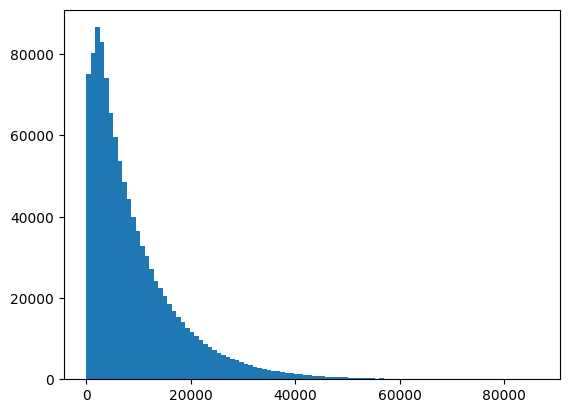

In [19]:
# The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session
import matplotlib.pyplot as plt
time_intervals = []

for session in sessions:
    actions = sorted(session['actions'], key=lambda x: x['time'])
    last_seen_dict = {}
    for action in actions:
        if action['name'] in last_seen_dict:
            time_intervals.append(action['time'] - last_seen_dict[action['name']])
        last_seen_dict[action['name']] = action['time']
delta_secs = [x.seconds for x in time_intervals]
values, bins, _ = plt.hist(delta_secs, bins=100)

In [20]:
delta_secs.sort()
p = 0.95
quantile = delta_secs[int(p*len(delta_secs))-1]
print("The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session is", quantile, "seconds")

The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session is 27426 seconds


### Stat tests

In [21]:
dates = df_wo_end['action_time'].apply(datetime.date)
days_actions = dates.value_counts()
df_stats = pd.DataFrame({'day':days_actions.index, 'actions_count': days_actions.values})
df_stats["weekday"] = df_stats['day'].apply(datetime.weekday)
df_stats["weekend"] = df_stats["weekday"] >= 5
df_stats

,day,actions_count,weekday,weekend
0,2019-09-25,2997,2,False
1,2021-02-27,2985,5,True
2,2020-10-22,2932,3,False
3,2020-08-08,2916,5,True
4,2020-03-11,2850,2,False
...,...,...,...,...
727,2021-04-03,1756,5,True
728,2020-01-13,1692,0,False
729,2021-03-10,1689,2,False
730,2019-09-20,840,4,False


In [22]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison

model = ols("actions_count ~ weekday", df_stats).fit()
res = anova_lm(model, typ=1)
res

,df,sum_sq,mean_sq,F,PR(>F)
weekday,1.0,3.264819e+04,32648.189117,0.60399,0.437311
Residual,730.0,3.945955e+07,54054.171915,NaN,NaN


Here I applied anova test to test hypothesis that average number of actions across all days is equal.

As p-value is 0.437 > 0.05, there is not enough evidence to claim that these values are different.

Q: Is there statistical difference of activity in different days of the week? \
A: No

In [23]:
model = ols("actions_count ~ weekend", df_stats).fit()
res = anova_lm(model, typ=1)
res

,df,sum_sq,mean_sq,F,PR(>F)
weekend,1.0,7.632438e+03,7632.437733,0.14111,0.707289
Residual,730.0,3.948456e+07,54088.440068,NaN,NaN


Again we can't decline hypothesis, that activity is equal at weekends and workdays, as p-value is 0.707 > 0.05.

Q: And between weekends and workdays? \
A: No.

### Data Visualisation

the barchart of different actions counts

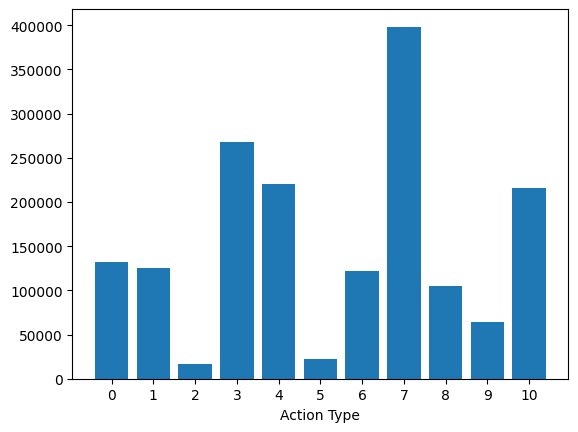

In [24]:
action_type_stat = df_wo_end['action_name'].value_counts()

plt.bar([int(x.split("_")[1]) for x in action_type_stat.index], action_type_stat.values)
plt.xticks(sorted([int(x.split("_")[1]) for x in action_type_stat.index]))

plt.xlabel("Action Type")

None

### the heatmap of action_i-action_j-count

In [25]:
import numpy as np
N_actions = len(action_type_stat)
trans_count = np.zeros((N_actions, N_actions), dtype=int)
def act_to_id(action):
    return int(action["name"].split("_")[1])
for session in sessions:
    actions = session['actions']
    for i in range(len(actions)-2):
        trans_count[act_to_id(actions[i]), act_to_id(actions[i+1])] += 1
trans_count

array([[ 9925,  9218,  1224, 20125, 16460,  1707,  9263, 29717,  7782,
         4841, 16132],
       [ 9346,  8733,  1164, 18788, 15523,  1619,  8771, 28157,  7549,
         4584, 15294],
       [ 1275,  1128,   154,  2493,  2019,   195,  1117,  3652,   973,
          605,  1999],
       [20228, 18908,  2491, 40636, 33427,  3445, 18438, 60393, 15855,
         9706, 32536],
       [16328, 15926,  2033, 33567, 27530,  2866, 15223, 49501, 13007,
         7965, 26797],
       [ 1663,  1714,   205,  3418,  2877,   303,  1563,  5073,  1331,
          866,  2811],
       [ 9073,  8538,  1113, 18703, 15407,  1492,  8505, 27755,  7200,
         4444, 14686],
       [29756, 28136,  3730, 60432, 49719,  5221, 27282, 89802, 23621,
        14227, 48793],
       [ 7778,  7526,  1005, 16022, 13011,  1318,  7316, 23483,  6169,
         3689, 12657],
       [ 4733,  4501,   580,  9515,  8161,   820,  4447, 14311,  3730,
         2192,  7841],
       [16292, 15177,  1962, 32304, 26614,  2784, 14849, 489

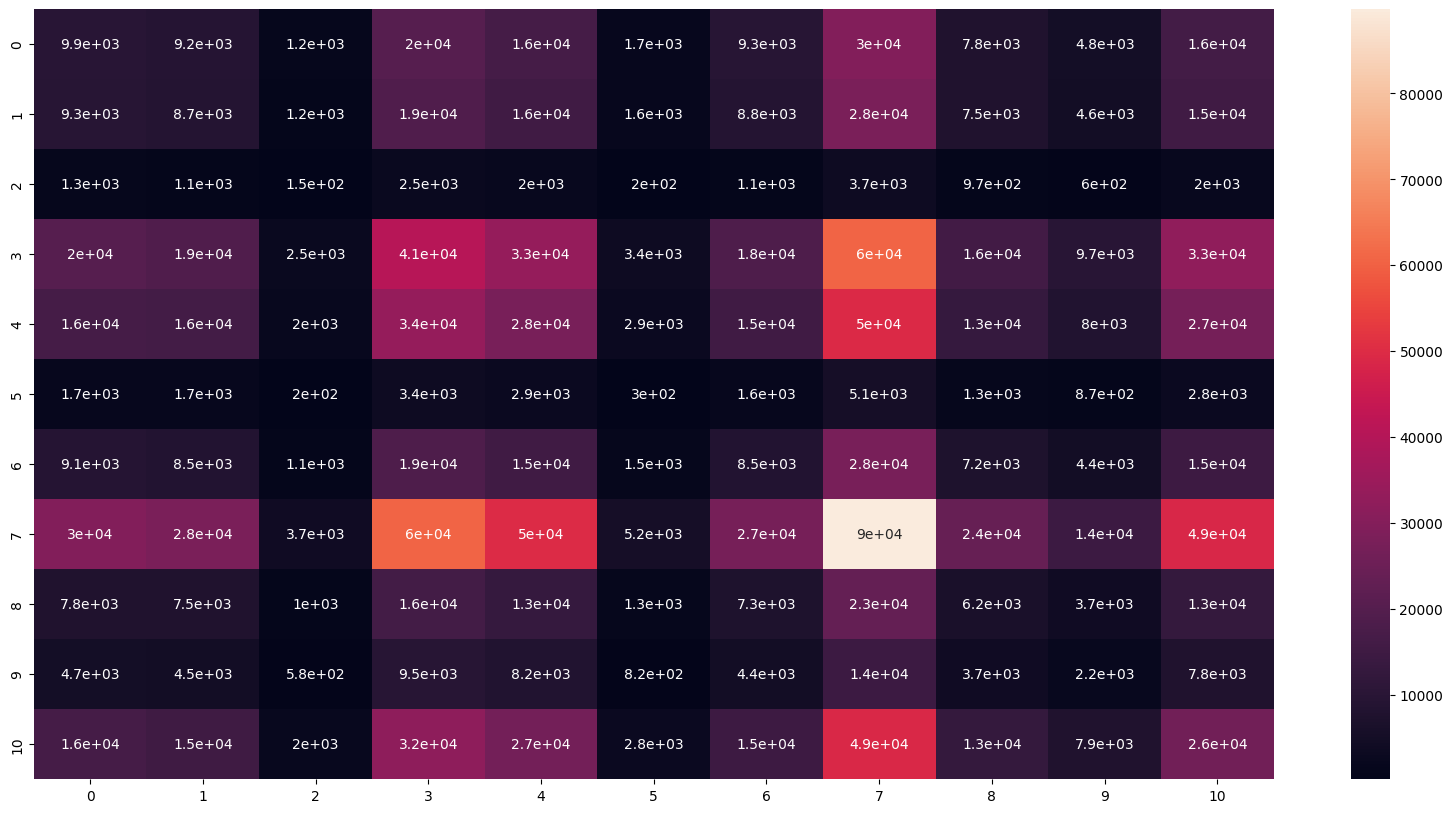

In [26]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.heatmap(trans_count, annot=True)
None

Additional plots

In [27]:
dates = df_wo_end['action_time'].apply(datetime.date)
days_stats = dates.value_counts().groupby(datetime.weekday)

In [28]:
days_stats = days_stats.apply(lambda x: x.values)
days_stats

action_time
0    [2833, 2738, 2612, 2607, 2584, 2578, 2576, 257...
1    [2820, 2794, 2775, 2722, 2711, 2691, 2662, 264...
2    [2997, 2850, 2780, 2764, 2709, 2699, 2681, 267...
3    [2932, 2828, 2814, 2764, 2760, 2706, 2620, 261...
4    [2756, 2756, 2709, 2634, 2626, 2626, 2590, 257...
5    [2985, 2916, 2831, 2789, 2765, 2683, 2655, 265...
6    [2733, 2701, 2668, 2644, 2585, 2581, 2562, 254...
Name: count, dtype: object

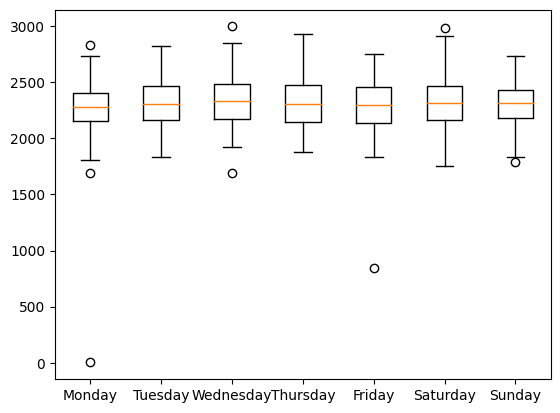

In [29]:
import calendar
plt.boxplot(days_stats)
plt.gca().set_xticklabels([calendar.day_name[x] for x in days_stats.index])
None

In [30]:
dayly_activity = df_wo_end['action_time'].apply(datetime.weekday).value_counts().sort_index()
dayly_activity

action_time
0    237143
1    241300
2    242789
3    241668
4    240307
5    243423
6    242125
Name: count, dtype: int64

In [31]:
weekend_workday_stats = dates.value_counts().groupby(lambda x: x.weekday() >= 5).apply(lambda x: x.values) # 1 -- weekend, 0 -- workday
weekend_workday_stats

action_time
False    [2997, 2932, 2850, 2833, 2828, 2820, 2814, 279...
True     [2985, 2916, 2831, 2789, 2765, 2733, 2701, 268...
Name: count, dtype: object